In [37]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

from wordle_rl.wordle_env import WordleEnv
from wordle_rl.wrappers import SequenceWrapper, ReshapeWrapper, TensorboardSummaries
from wordle_rl.wrappers import nature_dqn_env

import numpy as np
import torch
from wordle_rl.agent import RNNAgent
from wordle_rl.tokenizer import Tokenizer

In [38]:
num_letters = 29

env = WordleEnv()
env = SequenceWrapper(env, sos_token=1)
env = ReshapeWrapper(env)

In [39]:
tokenizer = Tokenizer()
game_voc_matrix = torch.FloatTensor(env.game_voc_matrix)

config = {
    "letter_tokens": len(tokenizer.index2letter),
    "guess_tokens": len(tokenizer.index2guess_state),
    "emb_dim": 16,
    "hid_dim": 128,
    "output_dim": len(tokenizer.index2letter),
    "game_voc_matrix": game_voc_matrix,
    "num_layers": 1,
    "output_len": 5,
    "sos_token": tokenizer.guess_state2index['<SOS>']
}

In [40]:
agent = RNNAgent(**config)
agent.load_state_dict(torch.load("model_weights/agent.pt"))
agent.to(torch.device("cuda"))
agent.eval()
agent.debug(False)

In [41]:
def transform2word(word_vector):
    letter_list = list(map(lambda x: env.tokenizer.index2letter[x], word_vector))
    return ''.join(letter_list)

def transform2vector(word_str):
    letter_list = list(map(lambda x: env.tokenizer.letter2index[x], word_str))
    return np.array(letter_list, dtype=int)

In [42]:
def compute_pattern(target: np.array, action: np.ndarray):
    equality_grid = np.equal.outer(action, target)
    pattern = np.full((5,), fill_value=tokenizer.guess_state2index['<MISS>'])

    # Green pass
    green_matches = np.diag(equality_grid).copy()
    pattern[green_matches] = tokenizer.guess_state2index['<RIGHT>']  # right
    equality_grid[green_matches, :] = False
    equality_grid[:, green_matches] = False

    # Yellow pass
    idx = np.argwhere(equality_grid == True)
    for i, j in idx:
        if equality_grid[i, j]:
            pattern[i] = tokenizer.guess_state2index['<CONTAINED>']  # misplaced
            equality_grid[:, j] = False
            equality_grid[i, :] = False
    return pattern, green_matches

In [54]:
from IPython.display import display, Markdown

def run_env(init_word=None, verbose=False):
    obs = env.reset()
    if init_word is not None:
        env.env.env.word[:] = transform2vector(init_word)
    word = env.env.env.word
    
    if verbose:
        print("--------")
        print(f"True word: {transform2word(word)}")

    done = False

    if verbose:
        print("Guesses:")

    actions = list()
    last_obs = None
    while not done:
        action = agent.act(obs)['actions'].squeeze()
        actions.append(action)
        last_obs = obs
        obs, rew, done, info = env.step(action)
        if verbose:
            print(f"{transform2word(action)} (total game reward = {rew[0]})")
        if done:
            break

    if verbose:
        print("--------")

    game_mat = last_obs[0][1].reshape(6, 6)[:, 1:].copy()
    game_mat[len(actions) - 1, :] = compute_pattern(word, action)[0]
    
    success = (rew[0] >= 9)
    
    return actions, game_mat, success, word

In [ ]:
from tqdm import tqdm

num_actions = list()
with open("data/possible_words.txt", "r") as f:
    for line in tqdm(f.readlines()):
        word = line.strip()
        actions, last_obs, success, _ = run_env(word)
        if success:
            num_actions.append(len(actions))
        else:
            num_actions.append('> 6')

100%|███████████████████████████████████████| 2315/2315 [01:30<00:00, 25.59it/s]


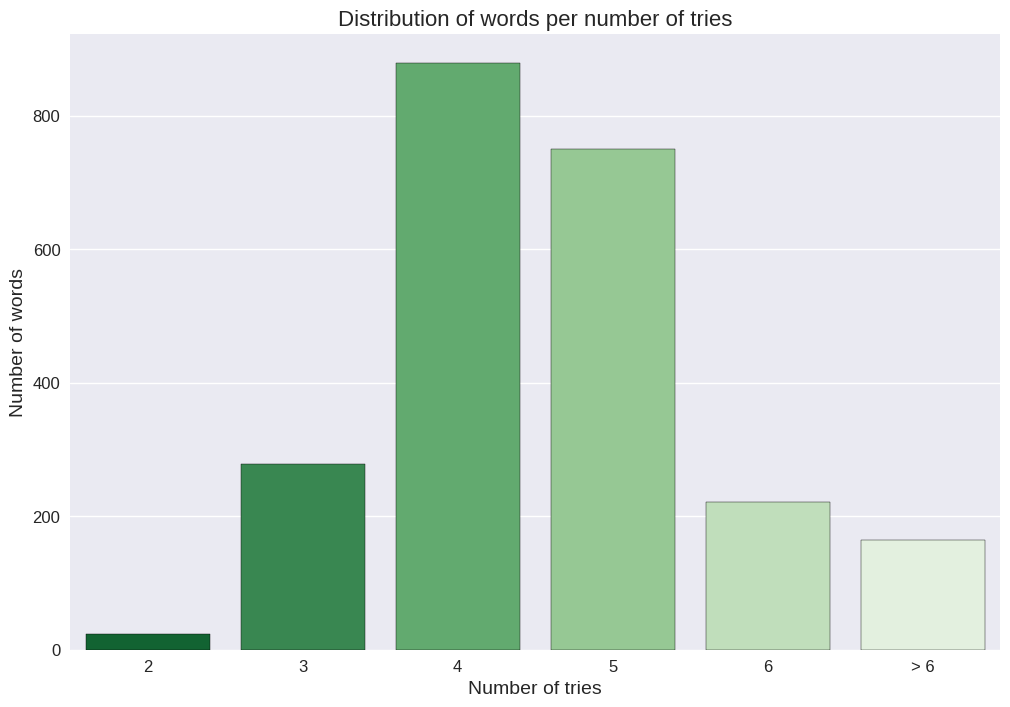

In [61]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 8))

plt.style.use('seaborn')
sns.set_palette("Greens_r")
ax.grid(True)
sns.countplot(x=num_actions, order=[2, 3, 4, 5, 6, '> 6'], ax=ax, edgecolor='black')
ax.set_title('Distribution of words per number of tries', fontsize=16)
ax.set_xlabel('Number of tries', fontsize=14)
ax.set_ylabel('Number of words', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [62]:
# mean episode length
np.mean(list(map(lambda x: 6 if x == "> 6" else x, num_actions)))

4.516630669546436

In [63]:
# mean success rate
np.mean(list(map(lambda x: 0 if x == "> 6" else 1, num_actions)))

0.9291576673866091

In [65]:
games = list()

for _ in range(12):
    actions, game_mat, success, word = run_env(verbose=True)
    games.append((actions, game_mat, success, word))

--------
True word: towel
Guesses:
saser (total game reward = 0.2)
betel (total game reward = 0.4)
cowed (total game reward = 0.6)
towel (total game reward = 10.0)
--------
--------
True word: tulle
Guesses:
saser (total game reward = 0.0)
beech (total game reward = 0.0)
cooze (total game reward = 0.2)
pling (total game reward = 0.0)
tulle (total game reward = 10.0)
--------
--------
True word: titan
Guesses:
saser (total game reward = 0.0)
boast (total game reward = 0.0)
clink (total game reward = 0.0)
ainga (total game reward = 0.2)
titan (total game reward = 10.0)
--------
--------
True word: depth
Guesses:
saser (total game reward = 0.0)
beech (total game reward = 0.4)
peony (total game reward = 0.2)
depth (total game reward = 10.0)
--------
--------
True word: foist
Guesses:
saser (total game reward = 0.0)
boost (total game reward = 0.6)
conch (total game reward = 0.2)
moist (total game reward = 0.8)
foist (total game reward = 10.0)
--------
--------
True word: seven
Guesses:
sase

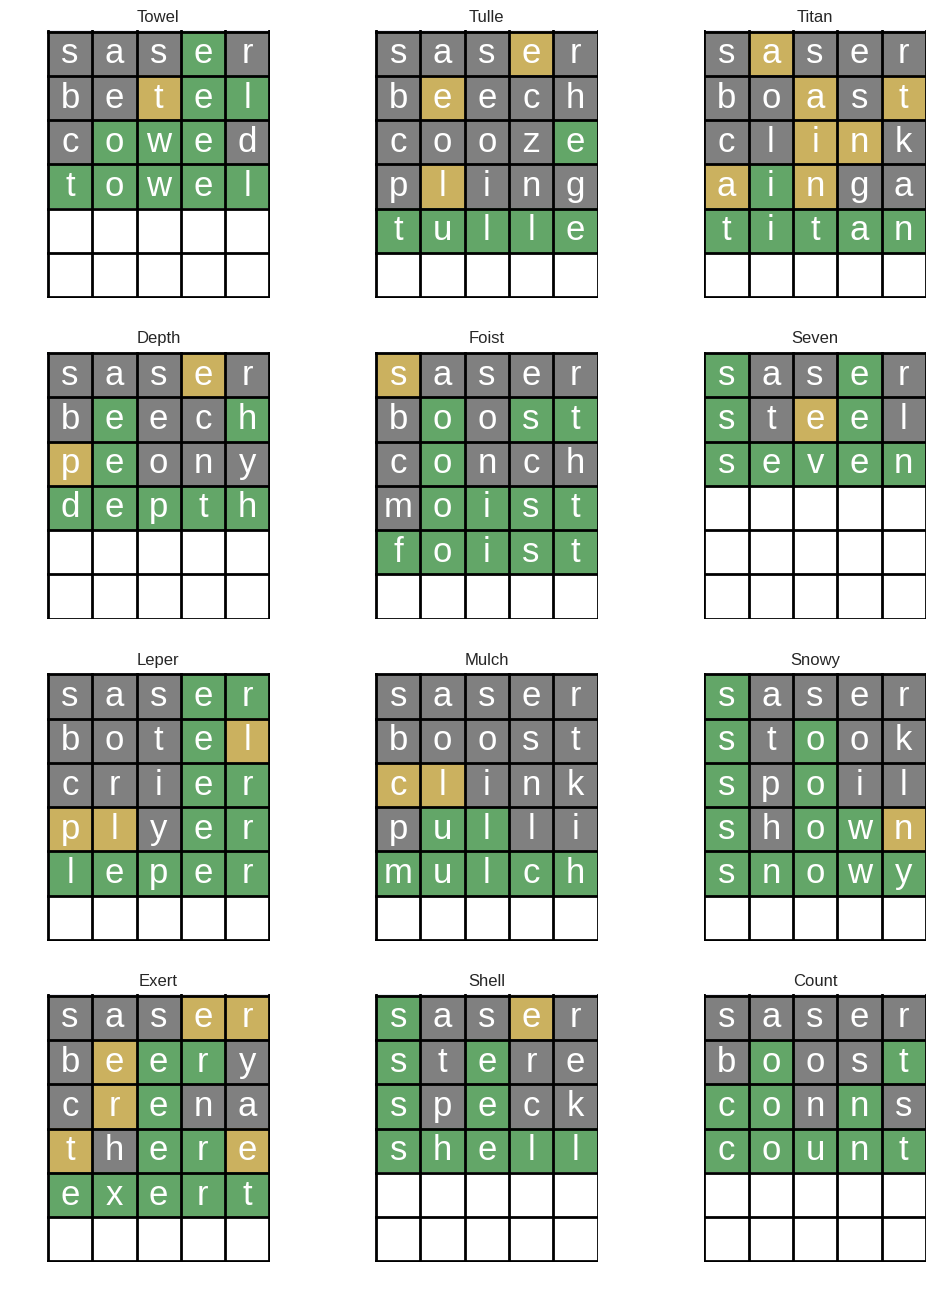

In [67]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import string

n, m = 4, 3
fig, ax = plt.subplots(n, m, figsize=(12, 16))

cmap = colors.ListedColormap(['white', '#63a668', '#cbb15f', 'gray'])
bounds = [-1, 0, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)

for k in range(n * m):
    actions, game_matrix, success, word = games[k]

    cmap = colors.ListedColormap(['white', '#63a668', '#cbb15f', 'gray'])
    bounds = [-1, 0, 3, 4, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    p, q = k // m, k % m
    ax[p, q].imshow(norm(game_matrix), cmap=cmap, vmin=0, vmax=5)

    for j in range(len(actions)):
        action = ''.join([tokenizer.index2letter[i] for i in actions[j]])
        for i in range(5):
            ax[p, q].text(i, j, action[i], c='white', fontsize=25, ha='center', va='center')

    # draw gridlines
    ax[p, q].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[p, q].set_xticks(np.arange(-0.5, 5.0, 1));
    ax[p, q].set_yticks(np.arange(-0.5, 6.0, 1));
    ax[p, q].set_xlim(-0.52, 4.51);
    ax[p, q].set_ylim(5.52, -0.53);

    ax[p, q].set_title(transform2word(word).capitalize());

    ax[p, q].tick_params(axis='x', colors=(0,0,0,0))
    ax[p, q].tick_params(axis='y', colors=(0,0,0,0))

plt.show()

### Run your own word

But note, that it should be contained in `data/allowed_words.txt`

In [71]:
init_word = 'actor'
run_env(init_word=init_word, verbose=True);

--------
True word: actor
Guesses:
saser (total game reward = 0.2)
boart (total game reward = 0.0)
creak (total game reward = 0.0)
actor (total game reward = 10.0)
--------
